## Clonando o repositório com os dados do problema

In [1]:
!rm -r IEC.PUC.Modelo.Notif.Dengue
!git clone https://github.com/cgalmeida/IEC.PUC.Modelo.Notif.Dengue.git

rm: cannot remove 'IEC.PUC.Modelo.Notif.Dengue': No such file or directory
Cloning into 'IEC.PUC.Modelo.Notif.Dengue'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 180 (delta 44), reused 73 (delta 44), pack-reused 105
Receiving objects: 100% (180/180), 63.77 KiB | 10.63 MiB/s, done.
Resolving deltas: 100% (104/104), done.


## Instalando o otimizador

In [2]:
! pip install adabelief-tf --quiet

## Fazendo os imports das libs necessárias

In [3]:
import os
from io import StringIO
import codecs
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from adabelief_tf import AdaBeliefOptimizer
import random as python_random

## Especificando o caminho para os dados

In [4]:
path_data = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados')
path_data

'IEC.PUC.Modelo.Notif.Dengue/dados'

In [5]:
path_base = os.path.join('IEC.PUC.Modelo.Notif.Dengue', 'dados', 'metadados')
path_base

'IEC.PUC.Modelo.Notif.Dengue/dados/metadados'

## Lendo os dados e armazenando em uma lista

In [9]:
def only_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file

def break_test(s):
    return 'SINAN NET' not in s.upper()

def read_file(file_path, line_pos):
    fp = codecs.open(file_path, 'r', encoding='latin-1')
    txt_lines = fp.readlines()[line_pos:]
    md = [s for s in txt_lines]
    data_lines = list(itertools.takewhile(break_test, txt_lines))
    fp.close()
    return data_lines

def to_dataframe(lst):
    return pd.read_csv(StringIO(''.join(lst)), sep=';', encoding = "ISO-8859-1")

def create_col_year(df, filename_var):
    df = df.replace('-', '0')
    df['Ano'] = filename_var[-8:-4]
    return df.drop(columns=['Total'])

def read_folder(path_data, filename_var):
    files = list(only_files(path_data))
    files.sort()    
    return [create_col_year(to_dataframe(read_file(os.path.join(path_data, file_name), 3)), file_name) for file_name in files if filename_var in file_name]

def read_base(filename_var):
    file_path = os.path.join(path_base, filename_var) + '.csv'
    return pd.read_csv(file_path, sep=';', encoding = "ISO-8859-1")

def merge_base(df_data, df_base):
    df_data.columns.values[0] = 'Descricao'
    return pd.merge(df_data, df_base, on='Descricao', how='inner')

def transpose_data(df):
    # df.set_index(['descricao','Ano','codigo']).stack().reset_index()
    return df.melt(id_vars=['Descricao','Ano','Codigo']).rename(columns={'variable':'Mes', 'value': 'Casos'})

def format_res(df):
    df_mes = read_base('mes_abr').rename(columns={'Codigo': 'Codigo_Mes', 'Descricao': 'Mes'})
    df_mes = pd.merge(df, df_mes, on=['Mes'], how='inner')
    df_mes['Periodo'] = df_mes.apply(lambda x: x.Ano + '.' + str(x.Codigo_Mes).zfill(2), axis=1)
    return df_mes

def type_col(df):
    df['Descricao'] = df['Descricao'].astype('str')
    df['Ano'] = df['Ano'].astype('int64')
    df['Mes'] = df['Mes'].astype('str')
    df['Casos'] = df['Casos'].astype('int64')
    df['Periodo'] = df['Periodo'].astype('str')
    return df

def prepare_data(path_data, filename_var):
    df_base = read_base(filename_var)
    res = [merge_base(i, df_base) for i in read_folder(path_data, filename_var)]
    res = [format_res(transpose_data(df)) for df in res]    
    res = pd.concat(res[:], axis=0).reset_index(drop=True)
    res = type_col(res)
    res = res.groupby(['Ano', 'Codigo', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index()
    return pd.merge(res, df_base, on=['Codigo'], how='inner')

def totalizar(df):
    return df.groupby(['Ano', 'Codigo_Mes', 'Periodo'], group_keys=False).sum().reset_index().drop(columns=['Codigo'])

In [10]:
%%time
filename_var = 'faixa'
data_list = prepare_data(path_data, filename_var = 'faixa')
data_list = totalizar(data_list)
data_list.head()

CPU times: user 155 ms, sys: 0 ns, total: 155 ms
Wall time: 157 ms


,Ano,Codigo_Mes,Periodo,Casos
0,2014,1,2014.01,4827
1,2014,2,2014.02,8594
2,2014,3,2014.03,11327
3,2014,4,2014.04,15311
4,2014,5,2014.05,9838


In [11]:
data = data_list['Casos'].values.tolist()

## Dando uma olhada no dataset

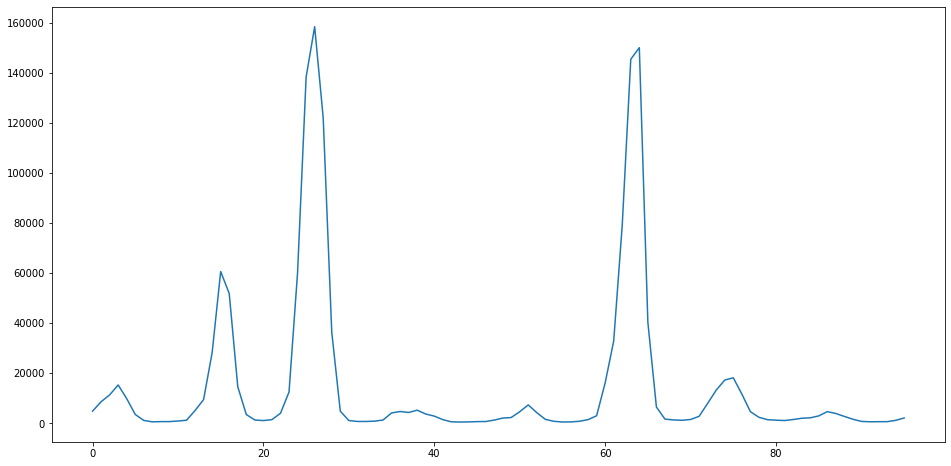

In [12]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(data)
plt.show()

## Processando o dado

In [34]:
dataframe =  data_list['Casos']
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform([[i] for i in dataset])

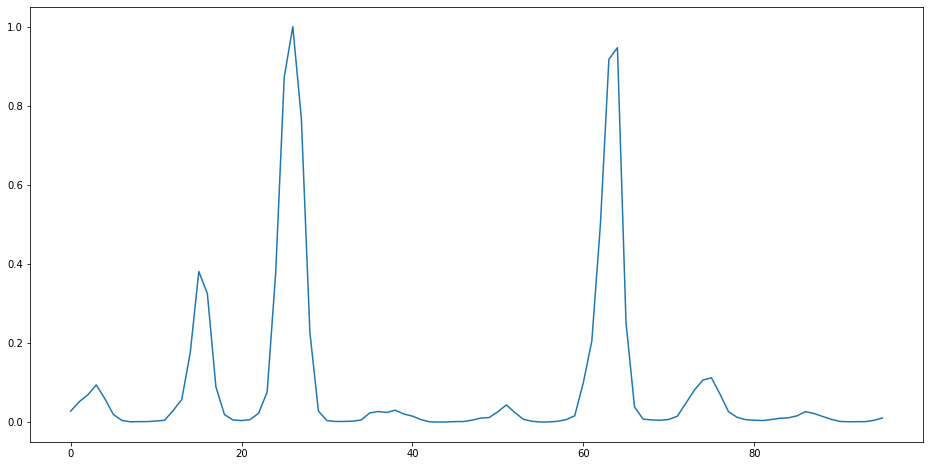

In [35]:
%matplotlib inline
plt.figure(figsize=(16,8))
plt.plot(dataset)
plt.show()

## Separando o dado em treino e teste

In [36]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

64 32


In [37]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
def plot_convergence(hist: tf.keras.callbacks.History, 
                     metric_name:str) -> None:
  figure = plt.gcf()
  figure.set_size_inches((15, 5))
  figure.patch.set_facecolor('darkgrey')
  
  ax = plt.axes()
  ax.set_facecolor("darkgrey")
  
  plt.xlabel('Epoch', fontsize=14)
  plt.xticks(fontsize=14)
  plt.ylabel(metric_name.title(), fontsize=14)
  plt.yticks(fontsize=14)

  plt.plot(range(1, len(hist.history[metric_name.lower()]) + 1), 
           hist.history[metric_name.lower()], marker='o', linewidth=3, 
           markersize=12)
  plt.plot(range(1, len(hist.history[f'val_{metric_name.lower()}']) + 1), 
           hist.history[f'val_{metric_name.lower()}'], marker='X', linewidth=3, 
           markersize=12)
  plt.legend([metric_name.title(), f'Validation {metric_name.title()}'], 
             fontsize=14)
  plt.show()

def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

In [38]:
learning_rate = 1e-4
ada_belief = AdaBeliefOptimizer(learning_rate=learning_rate, print_change_log = False)

## Preparando o dado

In [39]:
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Criando, compilando e treinando o modelo

In [40]:
%%time
reset_seeds() 
model = Sequential()
model.add(LSTM(30, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(30))
model.add(Dense(1))


CPU times: user 730 ms, sys: 14.4 ms, total: 744 ms
Wall time: 745 ms


In [41]:
model.compile(loss='mean_squared_error', 
              optimizer=ada_belief)

In [42]:
hist = model.fit(trainX,
                 trainY,
                 epochs=400,
                 batch_size=128,
                 validation_split=0.2)

Epoch 1/400
1/1 [==============================] - 7s 7s/step - loss: 0.0823 - val_loss: 0.0375
Epoch 2/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0823 - val_loss: 0.0375
Epoch 3/400
1/1 [==============================] - 0s 29ms/step - loss: 0.0823 - val_loss: 0.0375
Epoch 4/400
1/1 [==============================] - 0s 37ms/step - loss: 0.0823 - val_loss: 0.0375
Epoch 5/400
1/1 [==============================] - 0s 30ms/step - loss: 0.0823 - val_loss: 0.0375
Epoch 6/400
1/1 [==============================] - 0s 29ms/step - loss: 0.0823 - val_loss: 0.0374
Epoch 7/400
1/1 [==============================] - 0s 28ms/step - loss: 0.0823 - val_loss: 0.0374
Epoch 8/400
1/1 [==============================] - 0s 27ms/step - loss: 0.0823 - val_loss: 0.0374
Epoch 9/400
1/1 [==============================] - 0s 32ms/step - loss: 0.0823 - val_loss: 0.0374
Epoch 10/400
1/1 [==============================] - 0s 28ms/step - loss: 0.0823 - val_loss: 0.0374
Epoch 11/400
1/1 [===

## Plotando a convergência

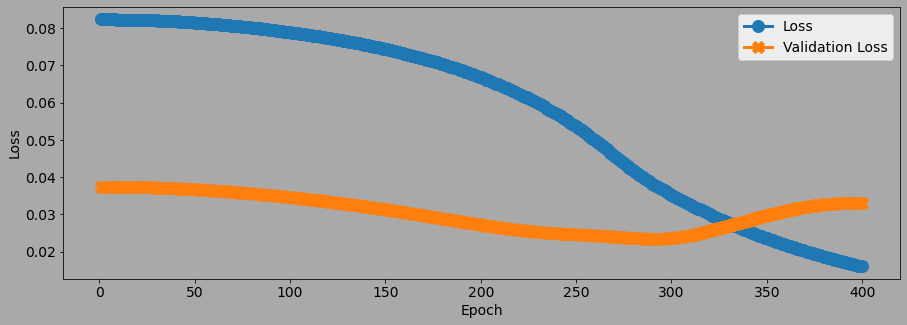

In [43]:
plot_convergence(hist, 'loss')

## Fazendo as predições para os dados

In [44]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 15ms/step
Train Score: 22023.08 RMSE
Test Score: 26512.49 RMSE


## Vendo a série prevista pela rede

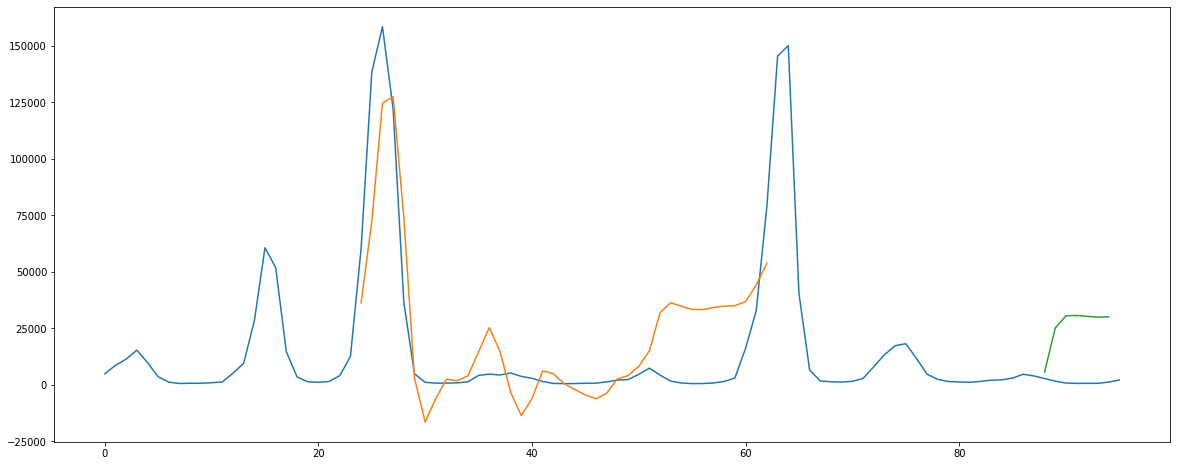

In [45]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(20,8))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()